In [51]:
using Pkg
Pkg.activate("..") # use the project in the parent directory (sets the environemnt)

using Random
using Statistics
using LogExpFunctions
using DataFrames, DataFramesMeta
using Plots

using Revise
using Camp

  Activating project at `~/workspace`


In [53]:
Camp.greet()

Hello from Camp modified!


# Rust bus Engine problem

Imagine that we want to model the decision to replace the engine on in a fleet of buses. This is the premise of a seminal paper by John Rust [Optimal Replacement of GMC Bus Engines: An Empirical Model of Harold Zurcher](http://www.its.caltech.edu/~mshum/stats/rust.pdf). Here is a simple version of it:

 - the state is $x_t$, the mileage of the engine
 - every period, the bus delivers profit as a function of $x_t$, call it $p(x_t)$
 - the bus owner Mr Zurcher, can decide to replace the engine at cost $C$ in which case $x_t$ goes back to $0$
 - the bus dies with probability a function of $x_t$ in which case the owner gets $0$
 - the owner discounts at rate $\beta$
 - every period, the bus accumulates a $u$ miles

Using our Bellman tool we can write the optimal decision for this problem recursively:

$$ V(x) = \max \{ p(x) + \lambda(x)\beta V(x+u) , -C + \beta V(0) \} $$
We can see that this will have a threshold property. In practice the decision won't be as clear as a simple threshold. We want to allow for some randomness. We then add a logit preference shock $\xi$ to the different between the two options. We then remember that we can transform the max into a log-sum-exp. 

$$ V(x) = \log\Big( \exp \Big[p(x) + \lambda(x)\beta V(x+u)\Big] + \exp \Big[ -C + \beta V(0) \Big] \Big) + \gamma $$

There is not hope to solve this problem in closed form. We tackle it numerically.

In [ ]:
# ----------------------------
# Utilities and model objects
# ----------------------------

"""
create_grids(; n=100)

Returns a NamedTuple of the grid and primitives used in the lab:
- x :: Vector{Float64} : mileage grid (0..100)
- In :: Vector{Int}    : index that maps state x -> next state (x+u), clipped at end
- lambda :: Vector{Float64} : "survival" / continuation prob (1 - break prob ultimately)
- P :: Vector{Float64} : period profit as a function of x
- beta :: Float64      : discount factor
"""
function create_grids(; n::Int=100)
    beta = 0.9
    x = range(0, 100; length=n) |> collect          # mileage grid

    lambda = 1.0 ./ (1 .+ exp.(0.1 .* (x .- 50.0))) # survival / continuation prob
    P = exp.(-0.01 .* x)                            # profit function

    In = [2:n; n]                                  # next-state index (x+u) with clipping
    return (x=x, In=In, lambda=lambda, beta=beta, P=P)
end

"""
value_iteration(C; n=100, maxiter=300)

Solves the Bellman equation:
    V(x) = log( exp(p(x) + lambda(x)*β V(x+u)) + exp(-C + β V(0)) ) + γ
where γ≈0.56 (Euler–Mascheroni for type-I EV shock).

Returns (V, iter_history) where:
- V :: Vector : converged value function on grid
- iter_history :: Vector of NamedTuples with (x, V, v1, v2, rep) for optional plotting
"""
function value_iteration(C::Float64; n::Int=100, maxiter::Int=300)
    γ = 0.56         # matches the constant added in the R code
    g = create_grids(n=n)
    x, In, λ, β, P = g.x, g.In, g.lambda, g.beta, g.P
    V = zeros(n)
    iter_hist = []

    for rep in 1:maxiter
        v1 = P .+ λ .* (β .* @view V[In])       # keep engine
        v2 = -C .+ β * V[1]                     # replace (constant across x)
        V2 = logsumexp(hcat(v1, fill(v2, n)), dims=2)[:] .+ γ

        # save light history (for optional plotting / inspection)
        push!(iter_hist, (x=copy(x), V=copy(V), v1=copy(v1), v2=v2, rep=rep))

        # convergence check
        if maximum(abs.(V2 .- V)) < 1e-6
            break
        end

        # update
        V = V2
    end
    
    return V, iter_hist
end

"""
choice_probabilities(V, C; grids)

Computes replacement probability:
    Pr(replace | x) = 1 / (1 + exp( v1 - v2 ))
where v1 = P(x) + λ(x)*β V(x+u), v2 = -C + β V(0)

Returns Vector{Float64} of size n.
"""
function choice_probabilities(V::AbstractVector{<:Real}, C::Float64; grids=nothing)
    g = grids === nothing ? create_grids(n=length(V)) : grids
    x, In, λ, β, P = g.x, g.In, g.lambda, g.beta, g.P
    v1 = P .+ λ .* (β .* @view V[In])
    v2 = -C .+ β * V[1]
    Pr = 1.0 ./ (1 .+ exp.(v1 .- v2))
    return Pr
end

# ----------------------------
# Simulation
# ----------------------------

"""
simulate_data(Pr, V, C; N=100, T=100, grids)

Simulates a fleet of N buses for T periods each.
State x is represented by the integer grid index (1..n). We track:
- i: bus id
- t: time
- x: mileage index (1..n; note that 1 corresponds to x=0 in the grid)
- l: alive indicator (1=alive, 0=dead)
- profit: realized period payoff
- R: replacement indicator (1=replace, 0=not)

Returns a DataFrame.
"""
function simulate_data(Pr::AbstractVector{<:Real}, V, C::Float64; N::Int=100, T::Int=100, grids=nothing)
    g = grids === nothing ? create_grids(n=length(Pr)) : grids
    n = length(Pr)
    xgrid, In, λ, β, P = g.x, g.In, g.lambda, g.beta, g.P

    rows = Int64[]
    i_vec = Int[]
    t_vec = Int[]
    x_vec = Int[]
    l_vec = Int[]
    profit_vec = Float64[]
    R_vec = Int[]

    # set seed if you want reproducibility
    # Random.seed!(4325342)

    for i in 1:N
        x = 1   # start at lowest mileage index
        l = 1   # alive
        for t in 1:T

            # if dead, just record and continue
            if l == 0
                push!(i_vec, i); 
                push!(t_vec, t); 
                push!(x_vec, 0); 
                push!(l_vec, 0)
                push!(profit_vec, 0.0); 
                push!(R_vec, 0)
                continue
            end

            # draw replacement choice & death
            r = rand()
            if r < Pr[x]
                R = 1
                profit = -C
            else
                R = 0
                profit = P[x]
                l = (rand() < λ[x]) ? 1 : 0
            end

            push!(i_vec, i) 
            push!(t_vec, t) 
            push!(x_vec, x)
            push!(l_vec, 1) # we die next period, so alive this period
            push!(profit_vec, profit)
            push!(R_vec, R)

            x = (R == 1) ? 1 : min(x + 1, n) # increment mileage or reset if replaced
        end
    end

    return DataFrame(
        i=i_vec, 
        t=t_vec, 
        x=x_vec, 
        l=l_vec, 
        profit=profit_vec, 
        R=R_vec)
end



simulate_data

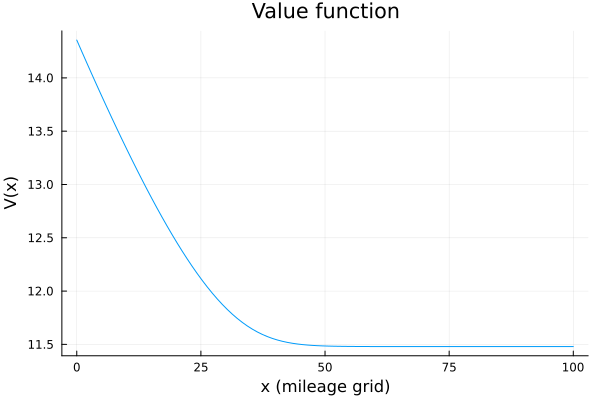

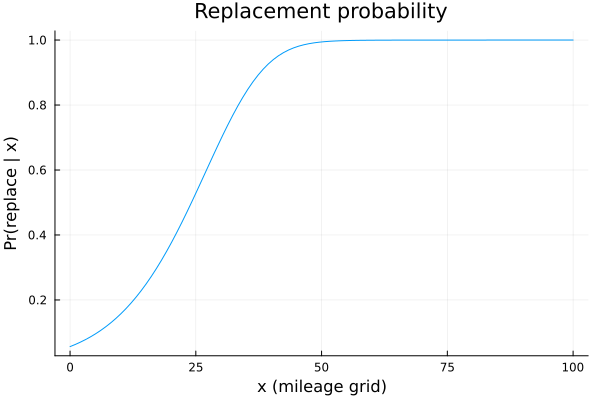

In [4]:
# Model size and parameter sweep
n = 100
C_true = 2.0

# 1) Solve the Bellman fixed point
V, hist = value_iteration(C_true; n=n, maxiter=300)

# 2) Choice probabilities
g = create_grids(n=n)
Pr = choice_probabilities(V, C_true; grids=g)

plot(g.x, V, xlabel="x (mileage grid)", ylabel="V(x)", title="Value function")
display(plot!(legend=false))

plot(g.x, Pr, xlabel="x (mileage grid)", ylabel="Pr(replace | x)",
        title="Replacement probability")
display(plot!(legend=false))

In [5]:
# 3) Simulate a dataset
data = simulate_data(Pr, V, C_true; N=100, T=25, grids=g)

println("Mean alive across buses (fraction of periods alive):")
mean_alive = combine(groupby(data, :i), :l => mean => :alive_mean)
println(mean(mean_alive.alive_mean))

data

Mean alive across buses (fraction of periods alive):
0.9408


Row,i,t,x,l,profit,R
,Int64,Int64,Int64,Int64,Float64,Int64
1,1,1,1,1,1.0,0
2,1,2,2,1,0.98995,0
3,1,3,3,1,0.980001,0
4,1,4,4,1,0.970152,0
5,1,5,5,1,0.960401,0
6,1,6,6,1,0.950749,0
7,1,7,7,1,0.941194,0
8,1,8,8,1,0.931735,0
9,1,9,9,1,0.922371,0


In [6]:
@chain data begin
    @subset(:i .== 5)                     # only alive observations
end

Row,i,t,x,l,profit,R
,Int64,Int64,Int64,Int64,Float64,Int64
1,5,1,1,1,1.0,0
2,5,2,2,1,0.98995,0
3,5,3,3,1,0.980001,0
4,5,4,4,1,0.970152,0
5,5,5,5,1,0.960401,0
6,5,6,6,1,0.950749,0
7,5,7,7,1,0.941194,0
8,5,8,8,1,-2.0,1
9,5,9,1,1,1.0,0


## Likelihood and estimating parameters

We can write the likelihood of the data

$$ \ell(\theta) = \sum_i 1[R_i = 1]  \log P_\theta(R=1 | X_i) + 1[R_i = 0]  \log P_\theta(R=0 | X_i) $$

In [7]:

# ----------------------------
# Likelihood (simple)
# ----------------------------

"""
loglik_C(data, C; n=100)

Given data (with columns i, t, x, l, profit, R) and a candidate replacement cost C,
recomputes V and choice probabilities, then calculates the log-likelihood of
observed replacements (only when l==1 as in the R code):

sum_{rows with l==1} [ log(Pr[x]) if R==1, else log(1-Pr[x]) ]

Returns the scalar log-likelihood value.
"""
function loglik_C(data::DataFrame, C::Float64; n::Int=100)
    V, _ = value_iteration(C; n=n, maxiter=100)           # same iteration count as lab-ish
    g = create_grids(n=n)
    Pr = choice_probabilities(V, C; grids=g)

    ll = 0.0
    @inbounds for row in 1:nrow(data)
        if data.l[row] == 1
            x = data.x[row]
            if x < 1 || x > n
                continue
            end
            if data.R[row] == 1
                ll += log(Pr[x] + eps())
            else
                ll += log(1 - Pr[x] + eps())
            end
        end
    end
    return ll
end

loglik_C

Max log-likelihood at C ≈ 2.034


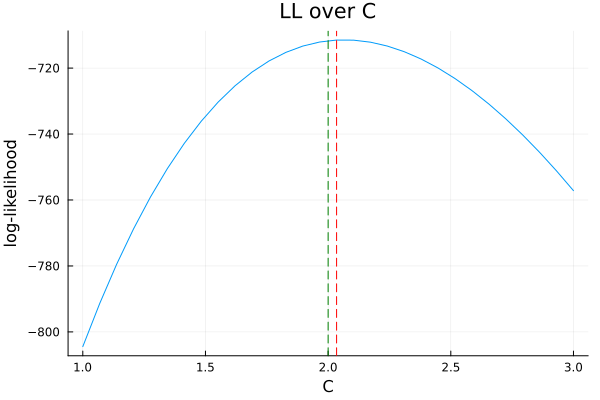

In [8]:
# 4) Simple likelihood sweep over C in [1, 3]
Cs = range(1.0, 3.0; length=30) |> collect
LL = [loglik_C(data, C; n=n) for C in Cs]

# Print the argmax
idx = argmax(LL)
println("Max log-likelihood at C ≈ $(round(Cs[idx], digits=3))")

plot(collect(Cs), LL, xlabel="C", ylabel="log-likelihood", title="LL over C")
vline!([Cs[idx]], color=:red, linewidth=1, linestyle=:dash)
vline!([2.0], color=:green, linewidth=1, linestyle=:dash)
display(plot!(legend=false))

In [35]:
function logsumexp3(x,y)
    m = max.(x, y)
    m + log.(exp.(x .- m) + exp.(y .- m))
end


function value_iteration_bis(C::Float64; n::Int=100, maxiter::Int=300)
    γ = 0.56         # matches the constant added in the R code
    g = create_grids(n=n)
    x, In, λ, β, P = g.x, g.In, g.lambda, g.beta, g.P
    V = zeros(n)

    for rep in 1:maxiter
        v1 = P .+ λ .* (β .* @view V[In])       # keep engine
        v2 = -C .+ β * V[1]                     # replace (constant across x)
        V2 = logsumexp3(v1, v2) .+ γ

        # convergence check
        # if maximum(abs.(V2 .- V)) < 1e-6
        #     println("Converged in $rep iterations")
        #     break
        # end

        # update
        V = V2
    end
    
    return V
end
value_iteration_bis(C_true; n=10000, maxiter=300)
@time value_iteration_bis(C_true; n=100000, maxiter=300)


  0.813095 seconds (7.21 k allocations: 1.792 GiB, 12.68% gc time)


100000-element Vector{Float64}:
 15.21386060002037
 15.21374165460006
 15.213622710167076
 15.21350376672153
 15.213384824263533
 15.2132658827932
 15.213146942310638
 15.213028002815964
 15.212909064309292
 15.212790126790727
  ⋮
 12.252487538086298
 12.252487537943118
 12.25248753779995
 12.252487537656794
 12.252487537513648
 12.252487537370515
 12.252487537227392
 12.252487537084281
 12.252487536941183

In [42]:
x = randn(100)
@time logsumexp3(x,x)

  0.000017 seconds (12 allocations: 5.438 KiB)


100-element Vector{Float64}:
  1.7433216673348717
  1.8723998691694437
  0.5258396862823242
  1.7143502630567484
  1.0718091809486388
 -0.9257684002035812
  1.1380193403243717
 -0.513257833895666
  1.2271431111277158
  0.8039312069758984
  ⋮
 -0.22414184030849282
  0.768742600605791
 -0.7155214431246556
  0.6747047447945541
  0.4777126822934491
  1.0348548637477577
  0.7018864966280632
  0.4884101152334276
  0.4546801102586382

In [50]:
"""
    logsumexp2!(out, a, b)

Compute `log(exp(a) + exp(b))` elementwise, storing result in `out`.
No allocations are performed (aside from what you pass in).
All vectors must have the same length.
"""
function logsumexp2!(out::AbstractVector, a::AbstractVector, b::AbstractVector)
    @inbounds @simd for i in eachindex(out, a, b)
        x = a[i]
        y = b[i]
        m = ifelse(x > y, x, y)  # branchless max
        out[i] = m + log1p(exp(-abs(x - y)))
    end
    return out
end

# Example usage:
a = randn(10000)
b = randn(10000)
out = similar(a)
logsumexp2!(out, a, b)

@time logsumexp2!(out, a, b)
println(out)


  0.000150 seconds
[1.1150024675383072, 2.9451177927914594, 0.8726570788207734, 1.74273079807274, 0.836892571979357, 0.12732094089254148, 0.37449902139848207, 1.0062873904351732, 0.8411700142958618, 1.2767225248862548, 0.5287133258992615, 0.9973600629263123, 0.004636134495231703, -0.41003094474194174, 1.4757775403338464, 1.1484223947488892, 0.04792537552674919, 0.9572395882457763, 1.1665290160406836, -0.09226309909168112, -0.20801538990200563, 0.8342117533697653, 0.5145881666210301, -0.4250898675247079, 1.3394989437587306, 1.4263725023554308, 0.5738043758950788, 0.23623222597345422, 1.1972102035842922, 1.1723139025918943, -0.6152263355560519, 1.6373696026177305, 1.08544674601475, 1.2369169710790788, 1.0808387539552253, 1.1179752119904824, 2.9245405780701743, -0.05091996299176926, 0.44107490467010835, 1.179224811053968, 1.271228269386607, 0.4989728935980596, -0.024993002721951874, 1.3188108362255124, 0.25403881715669724, 0.8429740645781449, 2.9662165979620405, 1.0606183719780078, 1.2596